In [1]:
import numpy as np

def daily_insolation_subroutine(lat, day, m):
      # Unpack orbital parameters
      ecc = m[1]  # Eccentricity
      omega = m[2] + 180  # Longitude of perihelion (precession angle), adding 180 degrees
      #     omega = np.unwrap(np.radians(omega))  # Convert to radians and unwrap
      if np.isscalar(omega):
            omega = np.array([omega])  # Make omega an array for unwrapping
            omega = np.unwrap(np.radians(omega))  # Unwrap and convert to radians
            omega = omega[0]  # Extract the scalar value again
      else:
            omega = np.unwrap(np.radians(omega))  # If omega is already an array, just unwrap

      epsilon = np.radians(m[3])  # Obliquity angle in radians

      # Convert latitude to radians
      lat_rad = np.radians(lat)

      # Estimate solar longitude (lambda) from day of year
      delta_lambda_m = (day - 80) * 2 * np.pi / 365.2422
      beta = np.sqrt(1 - ecc**2)
      lambda_m0 = -2 * ((1/2*ecc + 1/8*ecc**3) * (1 + beta) * np.sin(-omega) -
                        1/4*ecc**2 * (1/2 + beta) * np.sin(-2*omega) +
                        1/8*ecc**3 * (1/3 + beta) * np.sin(-3*omega))
      lambda_m = lambda_m0 + delta_lambda_m
      lambda_ = lambda_m + (2*ecc - 1/4*ecc**3) * np.sin(lambda_m - omega) + \
                  (5/4)*ecc**2 * np.sin(2*(lambda_m - omega)) + \
                  (13/12)*ecc**3 * np.sin(3*(lambda_m - omega))

      # Solar constant
      So = 1365

      # Calculate declination of the sun
      delta = np.arcsin(np.sin(epsilon) * np.sin(lambda_))

      # Hour angle at sunrise/sunset
      Ho = np.arccos(-np.tan(lat_rad) * np.tan(delta))
      # Handle no sunrise or sunset
      no_sunrise = (np.abs(lat_rad) >= np.pi/2 - np.abs(delta)) & (lat_rad * delta > 0)
      no_sunset = (np.abs(lat_rad) >= np.pi/2 - np.abs(delta)) & (lat_rad * delta <= 0)
      Ho[no_sunrise] = np.pi
      Ho[no_sunset] = 0

      # Calculate insolation
      Fsw = So/np.pi * (1 + ecc * np.cos(lambda_ - omega))**2 / \
            (1 - ecc**2)**2 * \
            (Ho * np.sin(lat_rad) * np.sin(delta) + np.cos(lat_rad) * np.cos(delta) * np.sin(Ho))

      return np.array(Fsw)


[474.44000994 474.29487061 474.14894083 ... 476.31104715 476.17661767
 476.04138392]


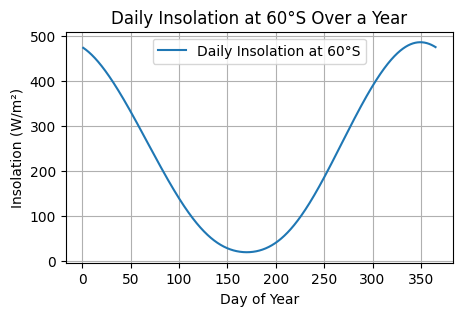

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming daily_insolation_subroutine has been defined as per the latest guidance

# Test parameters
day = np.arange(1, 365.2, 0.1)
m_row = np.array([-10, 0.019971, 293.86, 24.229])

# Call the function with -60 degrees latitude, representing 60S
Sol60S = daily_insolation_subroutine(-60, day, m_row)
print(Sol60S) # have tested, it is the same as the result running the same code in MATLAB

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(day, Sol60S, label='Daily Insolation at 60°S')
plt.xlabel('Day of Year')
plt.ylabel('Insolation (W/m²)')
plt.title('Daily Insolation at 60°S Over a Year')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
import xarray as xr
def we15_model (exptype = 'Full',nspace=400, nts=1000, mysolar=0., mycw=9.8, myA=193, dur=100, myD=0.6, myFb=4):
    """
    Run the WE15 model. Can vary parameters, resolution, run length and complexity of model as input to this function
    """                                                                                                                        
                                                                                                                          

    # Physical parameters
    D  = myD #0.6  # diffusivity for heat transport (W m^-2 K^-1)
    S1 = 338.;     # insolation seasonal dependence (W m^-2)
    A  = myA #193  # OLR when T = 0 (W m^-2)
    B  = 2.1       # OLR temperature dependence (W m^-2 K^-1)
    cw = mycw      # ocean mixed layer heat capacity (W yr m^-2 K^-1)
    S0 = 420.      # insolation at equator  (W m^-2)
    S2 = 240.      # insolation spatial dependence (W m^-2)
    a0 = 0.7       # ice-free co-albedo at equator
    a2 = 0.1       # ice=free co-albedo spatial dependence
    ai = 0.4       # co-albedo where there is sea ice
    Fb = myFb #4   # heat flux from ocean below (W m^-2)
    k  = 2;        # sea ice thermal conductivity (W m^-2 K^-1)
    Lf = 9.5;      # sea ice latent heat of fusion (W yr m^-3)
    cg = 0.01*cw;  # ghost layer heat capacity(W yr m^-2 K^-1)
    tau = 3e-5;    # ghost layer coupling timescale (yr)
    a_earth = 510072000./1e6 # million km^2

    # Time stepping parameters
    ##The default run in WE15, Fig 2 uses the time-stepping parameters: -------
    #n=400; % # of evenly spaced latitudinal gridboxes (equator to pole)
    #nt=1e3; % # of timesteps per year (approx lower limit of stability) 
    #dur=200; % # of years for the whole run

    n  = nspace;
    nt = nts;
    dt = 1/nt;

    
    #Spatial Grid -------------------------------------------------------------
    dx = 1.0/n    #grid box width
    x = np.arange(dx/2,1+dx/2,dx) #native grid
    xb = np.arange(dx,1,dx)

    ##Diffusion Operator (WE15, Appendix A) -----------------------------------
    lam = D/dx**2*(1-xb**2)
    L1=np.append(0, -lam); L2=np.append(-lam, 0); L3=-L1-L2
    diffop = - np.diag(L3) - np.diag(L2[:n-1],1) - np.diag(L1[1:n],-1);

    ##Definitions for implicit scheme on Tg
    cg_tau = cg/tau; 
    dt_tau = dt/tau; 
    dc = dt_tau*cg_tau;
    kappa = (1+dt_tau)*np.identity(n)-dt*diffop/cg;

    ##Seasonal forcing (WE15 eq.3)
    ty = np.arange(dt/2,1+dt/2,dt)
    if np.all(mysolar==0.): # if an insolation field is not provided, use the idealized function
        S = (np.tile(S0-S2*x**2,[nt,1])- np.tile(S1*np.cos(2*np.pi*ty),[n,1]).T*np.tile(x,[nt,1])); #totally symmetric at all lats
    else:
        S = mysolar
    S = np.vstack((S,S[0,:]))
    
    ##Further definitions
    M = B+cg_tau; 
    aw = a0-a2*x**2      # open water albedo
    kLf = k*Lf;
    
    #Set up output arrays, saving all timesteps of all years
    Efin  = np.zeros([dur,nt,n])
    Tfin  = np.zeros([dur,nt,n])
   
    #Initial conditions ------------------------------------------------------
    T = 7.5+20*(1-2*x**2);
    Tg = T; E = cw*T;
    
    #Integration (see WE15_NumericIntegration.pdf)----------------------------
    #Loop over Years ---------------------------------------------------------
    sia = np.zeros([dur,nt])
    for years in range(0,dur):
        #Loop within One Year-------------------------------------------------
        for i in range(0,int(nt)):
            #store spatial fields for all years

            #forcing
            alpha = aw*(E>0) + ai*(E<0)     #WE15, eq.4
            
            if 'NoAlb' in exptype:
                alpha = aw

            C = alpha*S[i,:]+cg_tau*Tg-A
            
            #surface temperature
            T0 = C/(M-kLf/E)                 #WE15, eq.A3
                           
            if 'NoTherm' in exptype:
                T = E/cw
                E = E+dt*(C-M*T+Fb);                 #WE15, eq.A2, Forward Euler on E
                Tg = np.linalg.solve(kappa,Tg+(dt_tau*(E/cw)))
                
                       
            else:
                T = E/cw*(E>=0)+T0*(E<0)*(T0<0);  #WE15, eq.9
                E = E+dt*(C-M*T+Fb);                 #WE15, eq.A2, Forward Euler on E
                Tg = np.linalg.solve(kappa-np.diag(dc/(M-kLf/E)*(T0<0)*(E<0)),
                                     Tg+(dt_tau*(E/cw*(E>=0)+(ai*S[i+1,:]-A)/(M-kLf/E)*(T0<0)*(E<0)))) #Implicit Euler on Tg
                
            Efin[years,i,:] = E
            Tfin[years,i,:] = T
                   
    lat = np.arcsin(np.linspace(0,1,nspace))*180./np.pi
    E_all = xr.DataArray(Efin,dims=('year','day','lat'),coords = {'year':np.arange(1,dur+1,1), 'day':np.linspace(1,366,nts), 'lat':lat}).to_dataset(name='E')
    T_all = xr.DataArray(Tfin,dims=('year','day','lat'),coords = {'year':np.arange(1,dur+1,1), 'day':np.linspace(1,366,nts), 'lat':lat}).to_dataset(name='T')
    
    ds = xr.merge([E_all, T_all]) 
    
    return ds

In [52]:

m_row = np.array([-10, 0.019971, 293.86, 24.229])

nt=1000
n=400

dx = 1/n
x = np.linspace(dx/2, 1-dx/2, n)
dt = 1/nt
ty = np.linspace(dt, 1, nt)
xx, tt = np.meshgrid(-x, ty)
lat = np.degrees(np.arcsin(xx))
day = tt * 365.24


inso_sh=daily_insolation_subroutine(lat,day, m_row)
ds=we15_model(exptype = 'Full',nspace=n, nts=nt, mysolar=inso_sh, mycw=9.8, myA=193, dur=100, myD=0.6, myFb=4)

C:\Users\zps19\AppData\Local\Temp\ipykernel_2880\1798849803.py:38: RuntimeWarning: invalid value encountered in arccos
  Ho = np.arccos(-np.tan(lat_rad) * np.tan(delta))


: 

In [ ]:
ds

In [13]:
import numpy as np
from scipy.interpolate import interp1d
import math


def sea_ice_EBM_R22_F(F, n, m, **kwargs):
    # Model parameters
    Config = kwargs.get('Config', 'Full')
    Sol = kwargs.get('Sol', 'SHSol')
    D = 0.625
    A = 194.8
    B = 2.1
    cw = 9.8
    a0 = 0.7
    a2 = 0.1
    ai = 0.4
    Fb = 5
    k = 2
    Lf = 9.5
    s0 = 420
    s1 = 338
    s2 = 240
    cg = 0.098
    tau = 3e-5
    nt = 1000
    dur = 100

    if Config=='NoIce_NoDiff':
        D=0

    # Grid setup
    dx = 1/n
    x = np.linspace(dx/2, 1-dx/2, n)
    dt = 1/nt

    # Diffusion operator
    xb = np.linspace(dx, 1.0-dx, n-1)
    lambda_ = D / dx**2 * (1 - xb**2)

    # Construct L1, L2, and L3
    L1 = np.append([0], -lambda_)
    L2 = np.append(-lambda_, [0])
    L3 = -L1 - L2

    # Create the diagonal components of the diffop matrix
    diagonal = np.diag(L3)
    off_diagonal_1 = np.diag(L2[:-1], 1)  # Upper diagonal
    off_diagonal_2 = np.diag(L1[1:], -1)  # Lower diagonal

    # Combine the components to form diffop
    diffop = diagonal + off_diagonal_1 + off_diagonal_2

    cg_tau = cg / tau
    dt_tau = dt / tau
    dc = dt_tau * cg_tau

    # Create the kappa matrix
    kappa = (1 + dt_tau) * np.eye(n) - dt * diffop / cg

    # Insolation
    ty = np.linspace(dt, 1, nt)
    xx, tt = np.meshgrid(-x, ty)
    lat = np.degrees(np.arcsin(xx))
    day = tt * 365.24

    if Sol == 'SHSol':
        S = daily_insolation_subroutine(lat, day, m)
    elif Sol == 'IdealSol':
        S = s0 - s1 * np.cos(2 * np.pi * tt) * xx - s2 * xx**2
    elif Sol == 'NHSol':
        S = daily_insolation_subroutine(-lat, day, m)
    
    # S = np.vstack((S,S[0,:]))
    S=S.T
    # # print('shape of S',S.shape)
    S = np.hstack((S, S[:, [0]]))  # Duplicate the first column at the end
    print('shape of S',S.shape)

    M = B+cg_tau
    # defin aw= a0-a2*x.^2; 
    aw = a0 - a2 * x**2
    kLf = k*Lf

    # Initial conditions
    T = 7.5 + 20 * (1 - 2 * x**2)
    Tg = T.copy()
    E = cw * T
    E1000 = np.nan * np.zeros((n, dur*nt))
    T1000 = np.nan * np.zeros((n, dur*nt))

    if Config=='NoIce' or Config=='NoIce_NoDiff': 
        ice=False
    else:
        ice=True
    print('starting run')
    # Integration loop
 
    for years in range(1, dur + 1):
        for i in range(1, nt + 1):
            # Store E and T at each timestep
            E1000[:, (years-1)*nt + i - 1] = E
            T1000[:, (years-1)*nt + i - 1] = T
            
            # Forcing calculation
            if ice:
                alpha = np.where(E > 0, aw, ai)  # Using np.where for element-wise condition

            else:
                alpha = aw
                A = 201.6  # Adjust A if ice is not present
                
            C = alpha * S[:, i - 1] + cg_tau * Tg - A + F  # Adjust index for Python's 0-based indexing
            
            # Surface temperature and enthalpy updates
            if ice:
                T0 = C / (M - kLf / E)
                T = E/cw*(E>=0)+T0*(E<0)*(T0<0)
                E = E + dt * (C - M * T + Fb)
                print('shape of E',E.shape)
                print('shape of Tg',Tg.shape)
                # Tg = np.linalg.solve(kappa-np.diag(dc/(M-kLf/E)*(T0<0)*(E<0)),
                #                      Tg+(dt_tau*(E/cw*(E>=0)+(ai*S[i+1,:]-A)/(M-kLf/E)*(T0<0)*(E<0)))) #Implicit Euler on Tg
                next_i = i + 1 if i + 1 < nt else i
                Tg_update_component = (E/cw*(E>=0) + (ai*S[next_i,:] - A + F) / (M - kLf / E) * (T0 < 0) * (E < 0))
                Tg = np.linalg.solve(kappa - np.diag(dc / (M - kLf / E) * (T0 < 0) * (E < 0)), Tg + dt_tau * Tg_update_component)

            else:
                T = E / cw
                E = E + dt * (C - M * T + Fb)
                Tg = np.linalg.solve(kappa, Tg + dt_tau * (E / cw))
                
        if years % 25 == 0:
            print(f'Year {years} complete')

    # Calculate climatological mean
    Ec = np.mean(E1000[:, -20*nt:], axis=1)
    Tc = np.mean(T1000[:, -20*nt:], axis=1)
    tc = ty[:nt]

    print(Ec.shape)
    print(x.shape)
    # Calculate ice area
    iceA = np.zeros_like(tc)
    earth_A = 510  # Earth's surface area in 10^6 km^2
    for i in range(Ec.shape[0]):  # Assuming the first dimension corresponds to different conditions or time steps
        e = Ec[i]  # Get the i-th set of enthalpy values across all latitudes
        f = interp1d(x, e, bounds_error=False, fill_value="extrapolate")  # Interpolate based on latitude (x) and enthalpy values (e)
        iceA[i] = earth_A / 2 * (1 - f(0))
        if np.min(e) > 0:
            iceA[i] = 0


    return lat, S, tc, iceA, Ec, Tc

# Note: The `daily_insolation_subroutine` function needs to be implemented according to its MATLAB counterpart.


# Call the model

In [14]:
# Example parameters
F = 0  # An example radiative forcing in W/m^2
n = 90  # Number of latitudinal grid boxes
m = [0, 0.017236, 101.37, 23.446]  # Orbital parameters example (eccentricity, longitude of perihelion, obliquity)

# Call the function
lat, S, tc, iceA, Ec, Tc = sea_ice_EBM_R22_F(F, n, m)

# Example output usage
import matplotlib.pyplot as plt

# Plotting the climatological mean temperature over the computed latitudes
plt.figure(figsize=(10, 6))
plt.plot(lat[:, 0], Tc, label='Climatological Mean Temperature')
plt.xlabel('Latitude')
plt.ylabel('Temperature (°C)')
plt.title('Climatological Mean Temperature vs. Latitude')
plt.legend()
plt.grid(True)
plt.show()



C:\Users\zps19\AppData\Local\Temp\ipykernel_1604\1798849803.py:38: RuntimeWarning: invalid value encountered in arccos
  Ho = np.arccos(-np.tan(lat_rad) * np.tan(delta))


shape of S (400, 1001)
starting run
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
sh

C:\Users\zps19\AppData\Local\Temp\ipykernel_1604\2850761096.py:112: RuntimeWarning: overflow encountered in multiply
  C = alpha * S[:, i - 1] + cg_tau * Tg - A + F  # Adjust index for Python's 0-based indexing
C:\Users\zps19\AppData\Local\Temp\ipykernel_1604\2850761096.py:117: RuntimeWarning: invalid value encountered in multiply
  T = E/cw*(E>=0)+T0*(E<0)*(T0<0)


shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
shape of E (400,)
shape of Tg (400,)
s

: 